In [1]:
from Bio import Phylo
import numpy as np
import matplotlib.pyplot as plt


def all_sublineage_ratios_array(newick_file):
    """
    Compute sublineage weight ratios for all internal nodes of a tree.
    
    Parameters
    ----------
    newick_file : str
        Path to the Newick tree file.
    
    Returns
    -------
    np.ndarray
        Flat array of sublineage weight ratios (child / parent) for all internal nodes.
    """
    tree = Phylo.read(newick_file, "newick")
    
    # Recursive function to count tips
    def count_tips(clade):
        if clade.is_terminal():
            return 1
        return sum(count_tips(child) for child in clade.clades)
    
    # Recursive function to compute ratios
    def compute_ratios(clade):
        ratios_list = []
        if not clade.is_terminal():
            parent_weight = count_tips(clade)
            for child in clade.clades:
                ratios_list.append(count_tips(child) / parent_weight)
            for child in clade.clades:
                ratios_list.extend(compute_ratios(child))
        return ratios_list
    
    all_ratios = compute_ratios(tree.root)
    return np.array(all_ratios)


def leaf_terminal_branch_ratio_all_branches(newick_file):
    """
    For each internal node, compute the ratio of the mean branch length of its 
    descendant leaves (terminal branches) to the mean branch length of all branches
    in the tree (internal + terminal).
    
    Parameters
    ----------
    newick_file : str
        Path to the Newick tree file.
    
    Returns
    -------
    np.ndarray
        Flat array of ratios (mean leaf branch length / mean branch length of all branches)
        for all internal nodes.
    """
    tree = Phylo.read(newick_file, "newick")
    
    # --- Compute mean branch length of all branches in the tree ---
    all_branch_lengths = [clade.branch_length for clade in tree.find_clades() 
                          if clade.branch_length is not None]
    mean_all_branches = np.mean(all_branch_lengths)
    
    # --- Recursive function to get terminal branch lengths under a clade ---
    def terminal_branch_lengths(clade):
        if clade.is_terminal():
            return [clade.branch_length if clade.branch_length is not None else 0.0]
        lengths = []
        for child in clade.clades:
            lengths.extend(terminal_branch_lengths(child))
        return lengths
    
    # --- Compute ratios for all internal nodes ---
    def compute_ratios(clade):
        ratios_list = []
        if not clade.is_terminal():
            term_lengths = terminal_branch_lengths(clade)
            mean_term = np.mean(term_lengths) if term_lengths else 0.0
            ratios_list.append(mean_term / mean_all_branches)
            for child in clade.clades:
                ratios_list.extend(compute_ratios(child))
        return ratios_list
    
    all_ratios = compute_ratios(tree.root)
    return np.array(all_ratios)





def leaf_terminal_branch_ratio_parents_of_leaves(newick_file):
    """
    For each internal node that is the parent of at least one leaf, 
    compute the ratio of the mean branch length of its descendant leaves 
    (terminal branches) to the mean branch length of all branches 
    (internal + terminal) in the tree.
    
    Parameters
    ----------
    newick_file : str
        Path to the Newick tree file.
    
    Returns
    -------
    np.ndarray
        Array of ratios (mean leaf branch length / mean branch length of all branches)
        for all internal nodes that have at least one leaf child.
    """
    tree = Phylo.read(newick_file, "newick")
    
    # --- Compute mean branch length of all branches in the tree ---
    all_branch_lengths = [clade.branch_length for clade in tree.find_clades() 
                          if clade.branch_length is not None]
    mean_all_branches = np.mean(all_branch_lengths)
    
    # --- Recursive function to get terminal branch lengths under a clade ---
    def terminal_branch_lengths(clade):
        if clade.is_terminal():
            return [clade.branch_length if clade.branch_length is not None else 0.0]
        lengths = []
        for child in clade.clades:
            lengths.extend(terminal_branch_lengths(child))
        return lengths
    
    # --- Collect ratios only for nodes that have at least one leaf child ---
    ratios_list = []
    for clade in tree.find_clades():
        if not clade.is_terminal():
            # Check if it has at least one leaf child
            leaf_children = [child for child in clade.clades if child.is_terminal()]
            if leaf_children:
                term_lengths = terminal_branch_lengths(clade)
                mean_term = np.mean(term_lengths) if term_lengths else 0.0
                ratios_list.append(mean_term / mean_all_branches)
    
    return np.array(ratios_list)







In [2]:
from Bio import Phylo
import numpy as np

def leaf_terminal_branch_ratio_parents_of_leaves2(newick_file):
    """
    For each internal node that is the parent of at least one leaf,
    compute the ratio:
        mean branch length of descendant leaves (terminal branches)
        /
        mean branch length of the lineage leading to that node
        (all branches along root → node path).
    
    Parameters
    ----------
    newick_file : str
        Path to the Newick tree file.
    
    Returns
    -------
    list of (clade, ratio)
        List of tuples with the clade and its ratio.
    """
    tree = Phylo.read(newick_file, "newick")
    
    # --- helper: get terminal branch lengths under a clade ---
    def terminal_branch_lengths(clade):
        if clade.is_terminal():
            return [clade.branch_length if clade.branch_length is not None else 0.0]
        lengths = []
        for child in clade.clades:
            lengths.extend(terminal_branch_lengths(child))
        return lengths
    
    # --- helper: get branch lengths along lineage root -> clade ---
    def lineage_branch_lengths(clade, tree):
        path = tree.get_path(clade)
        lengths = [c.branch_length for c in path if c.branch_length is not None]
        return lengths
    
    ratios_list = []
    for clade in tree.find_clades():
        if not clade.is_terminal():
            # node must have at least one leaf child
            leaf_children = [child for child in clade.clades if child.is_terminal()]
            if leaf_children:
                term_lengths = terminal_branch_lengths(clade)
                lineage_lengths = lineage_branch_lengths(clade, tree)
                
                mean_term = np.mean(term_lengths) if term_lengths else 0.0
                mean_lineage = np.mean(lineage_lengths) if lineage_lengths else 0.0
                
                if mean_lineage > 0:
                    ratios_list.append((clade, mean_term / mean_lineage))
    
    return ratios_list


In [23]:
from Bio import Phylo
import numpy as np

def parent_of_leaves_ratios_array_fast(newick_file):
    """
    Faster version: precompute root-to-node path branch lengths.
    """
    tree = Phylo.read(newick_file, "newick")

    # Precompute for each clade the list of branch lengths on root→clade path
    path_lengths = {}

    def dfs(clade, path):
        path_lengths[clade] = path[:]  # copy of the current path
        for child in clade.clades:
            bl = child.branch_length if child.branch_length else 0.0
            dfs(child, path + [bl])

    dfs(tree.root, [])

    ratios = []
    for clade in tree.find_clades():
        if not clade.is_terminal():
            if all(child.is_terminal() for child in clade.clades):
                # parent → leaf branch lengths
                term_lengths = [
                    child.branch_length if child.branch_length is not None else 0.0
                    for child in clade.clades
                ]
                mean_term = np.mean(term_lengths) if term_lengths else 0.0

                # root → parent path branch lengths (precomputed)
                lineage_lengths = path_lengths[clade]
                mean_lineage = np.mean(lineage_lengths) if lineage_lengths else 0.0

                if mean_lineage > 0:
                    ratios.append(mean_term / mean_lineage)

    return np.array(ratios)

b = parent_of_leaves_ratios_array_fast("../../data_directed_evolution/TreeSingleThread_PSE_round20.nwk")

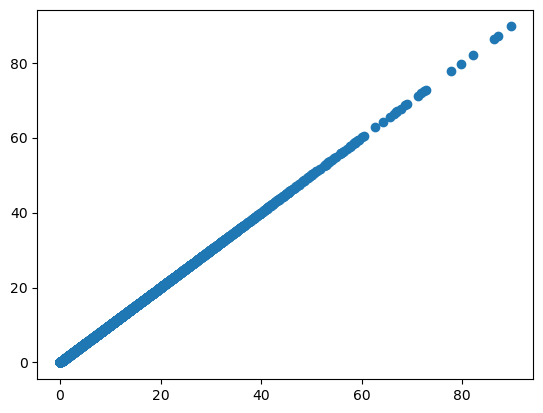

In [22]:
plt.scatter(a,b)

In [28]:
import matplotlib.pyplot as plt

def plot_tree_metrics(files, labels, colors, title="tree_metrics"):
    """
    Plot and save histograms of:
    1. Sublineage weight ratios (all internal nodes)
    2. Mean terminal / mean branch length ratios (all internal nodes)
    
    Parameters
    ----------
    files : list of str
        List of Newick tree files
    labels : list of str
        Labels for each tree
    colors : list of str
        Colors for plotting each tree
    title : str

    
        Title string used for saving the figure (default: "tree_metrics")
    """
    plt.figure(figsize=(12, 5))

    # --- Sublineage weight ratios ---
    plt.subplot(1, 2, 1)
    for file, lbl, col in zip(files, labels, colors):
        sub_lin_weight_ratio = all_sublineage_ratios_array(file)
        plt.hist(sub_lin_weight_ratio,
                 bins=50,
                 histtype='step',
                 linewidth=2.0,
                 density=True,
                 label=lbl,
                 color=col)
        print(file)
    plt.xlabel("Sublineage weight ratio (child/parent)")
    plt.ylabel("PDF")
    plt.yscale("log")
    plt.title("Sublineage Weight Ratios")
    plt.legend()
    plt.grid(True, which="both", linestyle="--", alpha=0.5)

    # --- Mean terminal / mean branch length ratios ---
    plt.subplot(1, 2, 2)
    for file, lbl, col in zip(files, labels, colors):
        term_branch_ratio = parent_of_leaves_ratios_array_fast(file)
        plt.hist(term_branch_ratio,
                 bins=50,
                 histtype='step',
                 linewidth=2.0,
                 density=True,
                 label=lbl,
                 color=col)
        print(file)
    plt.xlabel("Mean terminal / mean branch length")
    plt.ylabel("PDF")
    plt.yscale("log")
    plt.title("Terminal vs Branch Length Ratios")
    plt.legend()
    plt.grid(True, which="both", linestyle="--", alpha=0.5)

    plt.tight_layout()

    # --- Save and show ---
    filename = title.lower().replace(" ", "_") + ".png"
    plt.savefig(filename, dpi=300)
    print(f"✅ Figure saved as {filename}")
    plt.show()


../../data_directed_evolution/TreeSingleThread_PSE_round20.nwk
../../data_directed_evolution/TreeSingleThread_PSE_mcmc_samples100000_T1.3_steps120_pairs10000.nwk
../../data_directed_evolution/TreeSingleThread_nodupl_PSE_popgen_samples1000000_T12.0_mu0.03_mubind-50.0_pairs10000.fa.nwk
../../data_directed_evolution/TreeSingleThread_PSE_mcmctree_T1.4_steps110_pairs10000.nwk
../../data_directed_evolution/TreeSingleThread_PSE_round20.nwk
../../data_directed_evolution/TreeSingleThread_PSE_mcmc_samples100000_T1.3_steps120_pairs10000.nwk
../../data_directed_evolution/TreeSingleThread_nodupl_PSE_popgen_samples1000000_T12.0_mu0.03_mubind-50.0_pairs10000.fa.nwk
../../data_directed_evolution/TreeSingleThread_PSE_mcmctree_T1.4_steps110_pairs10000.nwk
✅ Figure saved as pse.png


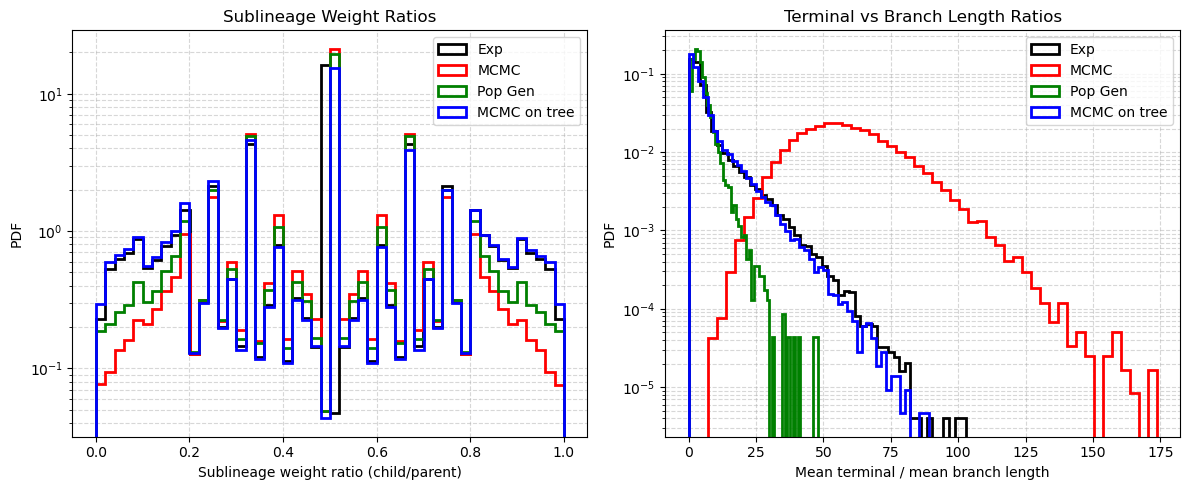

In [29]:
files = [
    "../../data_directed_evolution/TreeSingleThread_PSE_round20.nwk",
    "../../data_directed_evolution/TreeSingleThread_PSE_mcmc_samples100000_T1.3_steps120_pairs10000.nwk",
    "../../data_directed_evolution/TreeSingleThread_nodupl_PSE_popgen_samples1000000_T12.0_mu0.03_mubind-50.0_pairs10000.fa.nwk",
    "../../data_directed_evolution/TreeSingleThread_PSE_mcmctree_T1.4_steps110_pairs10000.nwk"
]
labels = ["Exp", "MCMC", "Pop Gen", "MCMC on tree"]
colors = ["black", "red", "green", "blue"]

plot_tree_metrics(files, labels, colors, title="PSE")


../../data_directed_evolution/TreeSingleThread_PSE_round20.nwk
../../data_directed_evolution/TreeSingleThread_TEM_round12.nwk
../../data_directed_evolution/TreeSingleThread_AAC6_round8.nwk
../../data_directed_evolution/TreeSingleThread_DHFR_round15.nwk
../../data_directed_evolution/TreeSingleThread_PSE_round20.nwk
../../data_directed_evolution/TreeSingleThread_TEM_round12.nwk
../../data_directed_evolution/TreeSingleThread_AAC6_round8.nwk
../../data_directed_evolution/TreeSingleThread_DHFR_round15.nwk
✅ Figure saved as all_exp.png


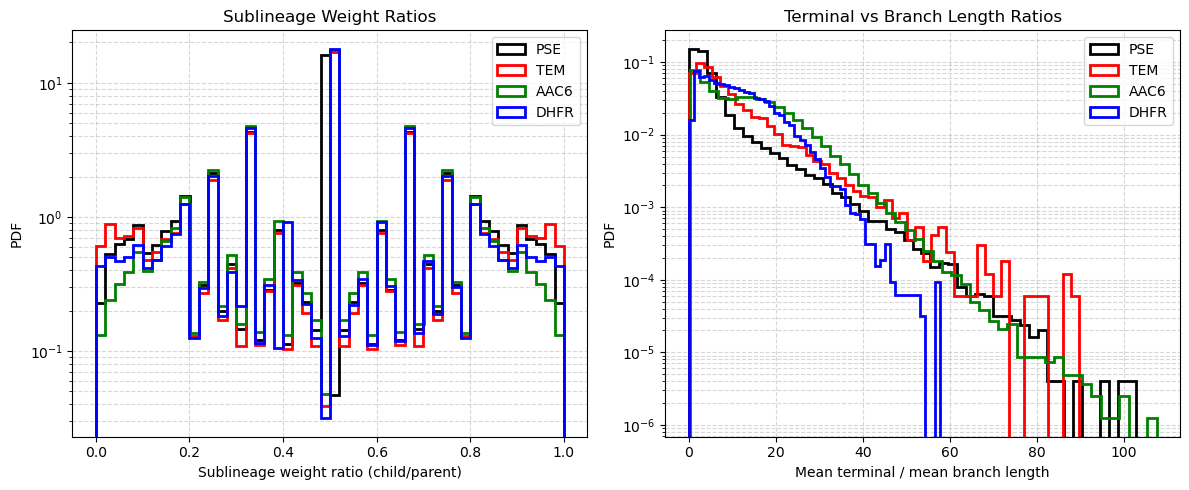

In [30]:
files = [
    "../../data_directed_evolution/TreeSingleThread_PSE_round20.nwk",
    "../../data_directed_evolution/TreeSingleThread_TEM_round12.nwk",
    "../../data_directed_evolution/TreeSingleThread_AAC6_round8.nwk",
    "../../data_directed_evolution/TreeSingleThread_DHFR_round15.nwk",
]

labels = ["PSE", "TEM", "AAC6", "DHFR"]
colors = ["black", "red", "green", "blue"]

plot_tree_metrics(files, labels, colors, title="All_exp")


In [ ]:
files = [
    "../../data_directed_evolution/TreeSingleThread_PSE_round20.nwk",
    "../../data_directed_evolution/TreeSingleThread_PSE_mcmc_samples100000_T1.3_steps120_pairs10000.nwk",
    "../../data_directed_evolution/TreeSingleThread_nodupl_PSE_popgen_samples1000000_T12.0_mu0.03_mubind-50.0_pairs10000.fa.nwk",
    "../../data_directed_evolution/TreeSingleThread_PSE_mcmctree_T1.4_steps110_pairs10000.nwk",
    "../../data_directed_evolution/TreeSingleThread_PSE_neutral_samples100000_T0.0_mu0.012_mubind0.0_pairs10000.nwk"
]



../../data_directed_evolution/TreeSingleThread_PSE_round20.nwk
../../data_directed_evolution/TreeSingleThread_PSE_mcmc_samples100000_T1.3_steps120_pairs10000.nwk
../../data_directed_evolution/TreeSingleThread_nodupl_PSE_popgen_samples1000000_T12.0_mu0.03_mubind-50.0_pairs10000.fa.nwk
../../data_directed_evolution/TreeSingleThread_PSE_mcmctree_T1.4_steps110_pairs10000.nwk
../../data_directed_evolution/TreeSingleThread_PSE_neutral_samples100000_T0.0_mu0.012_mubind0.0_pairs10000.nwk


/tmp/ipykernel_20880/1994543037.py:67: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig("../../pse_cdf_branch_length.png", dpi = 700)
/opt/conda/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


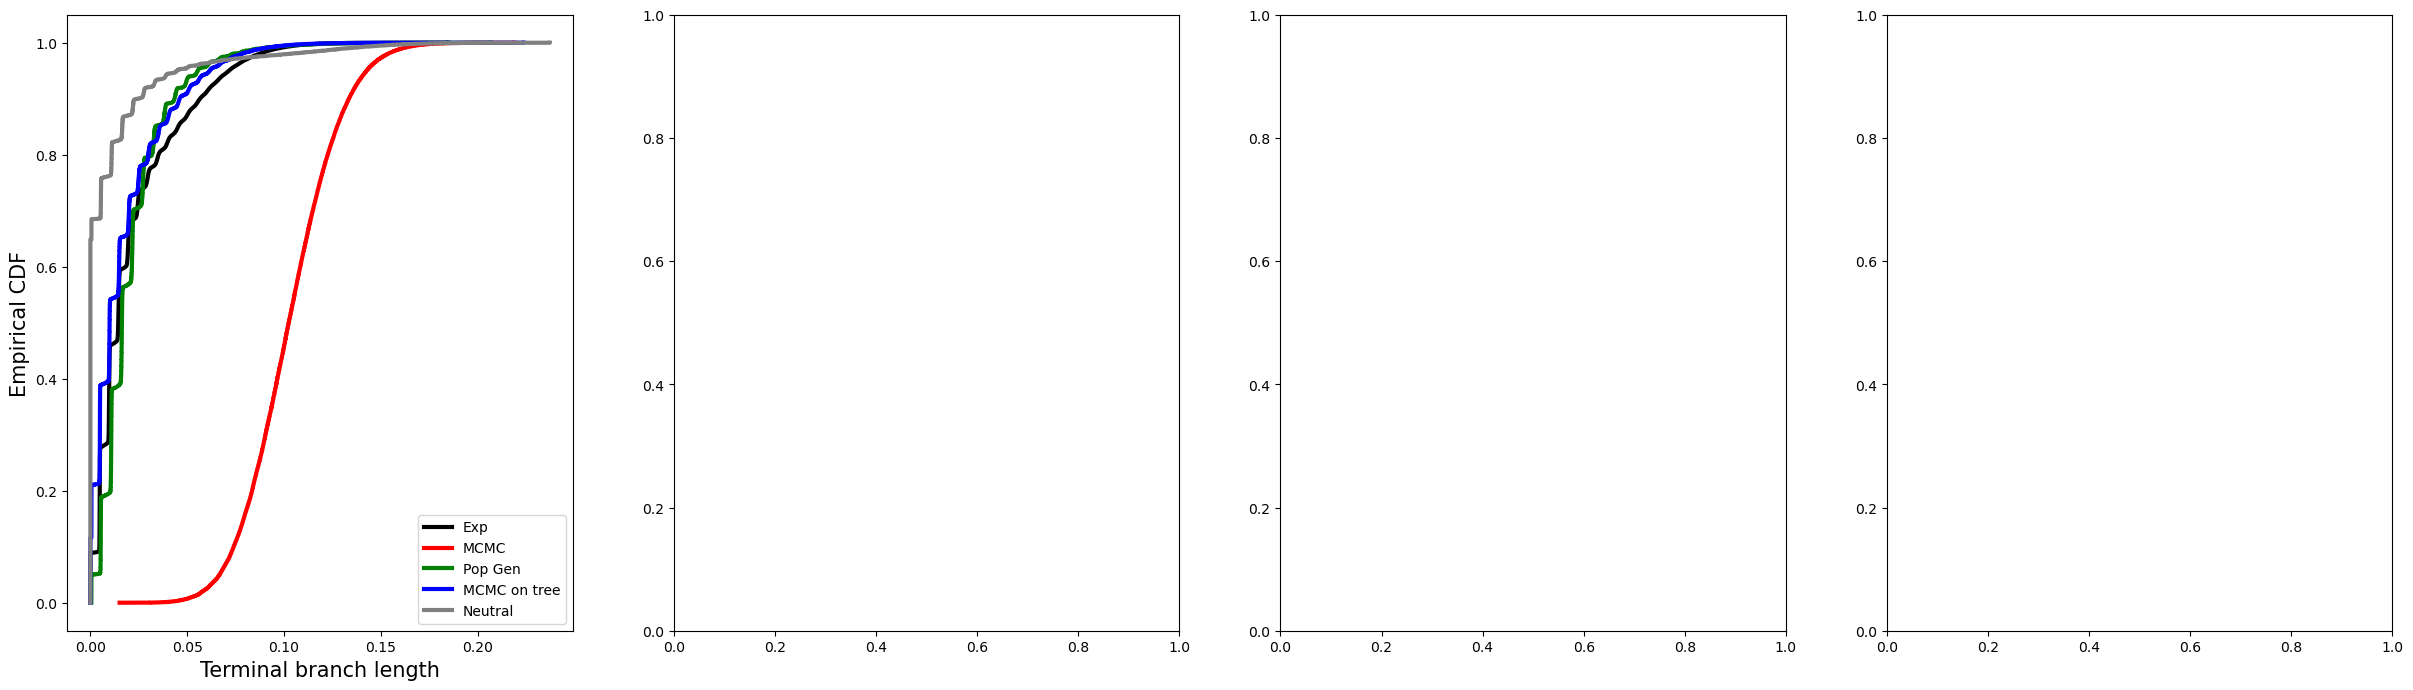

In [4]:
from Bio import Phylo
import numpy as np
import matplotlib.pyplot as plt

def terminal_branch_length_cdf(newick_file, ax=None, label=None, color=None):
    """
    Compute and optionally plot the empirical CDF of terminal branch lengths.
    
    Parameters
    ----------
    newick_file : str
        Path to the Newick tree file.
    ax : matplotlib.axes.Axes, optional
        Axis to plot on. If None, a new figure is created.
    label : str, optional
        Label for the curve (useful when comparing multiple trees).
    color : str, optional
        Color for the curve.
    
    Returns
    -------
    lengths : np.ndarray
        Sorted terminal branch lengths.
    cdf : np.ndarray
        Corresponding CDF values (from 0 to 1).
    """
    tree = Phylo.read(newick_file, "newick")
    
    # --- Extract terminal branch lengths ---
    lengths = [clade.branch_length for clade in tree.get_terminals() 
               if clade.branch_length is not None]
    lengths = np.array(lengths)
    lengths.sort()
    
    # --- Compute empirical CDF ---
    cdf = np.arange(1, len(lengths)+1) / len(lengths)
    
    ax.plot(lengths, cdf, linewidth = 3., drawstyle="steps-post", label=label, color=color)
    ax.set_xlabel("Terminal branch length", fontsize = 15)
    ax.set_ylabel("Empirical CDF", fontsize = 15)
    #ax.set_title("Cumulative distribution of terminal branch lengths")
    if label is not None:
        ax.legend()
    
    return lengths, cdf


files = [
    "../../data_directed_evolution/TreeSingleThread_PSE_round20.nwk",
    "../../data_directed_evolution/TreeSingleThread_PSE_mcmc_samples100000_T1.3_steps120_pairs10000.nwk",
    "../../data_directed_evolution/TreeSingleThread_nodupl_PSE_popgen_samples1000000_T12.0_mu0.03_mubind-50.0_pairs10000.fa.nwk",
    "../../data_directed_evolution/TreeSingleThread_PSE_mcmctree_T1.4_steps110_pairs10000.nwk",
    "../../data_directed_evolution/TreeSingleThread_PSE_neutral_samples100000_T0.0_mu0.012_mubind0.0_pairs10000.nwk"
]
labels = ["Exp", "MCMC", "Pop Gen", "MCMC on tree", "Neutral"]
colors = ["black", "red", "green", "blue", "grey"]

fig, axs = plt.subplots(1, 4, figsize=(30, 8), sharey=False)

i = 0
for path, label, color in zip(files, labels, colors):
    print(path)
    terminal_branch_length_cdf(path,label=label, ax = axs[0], color=color)
    i+=1


plt.savefig("../../pse_cdf_branch_length.png", dpi = 700)


../../data_directed_evolution/TreeSingleThread_PSE_round20.nwk
../../data_directed_evolution/TreeSingleThread_PSE_mcmc_samples100000_T1.3_steps120_pairs10000.nwk
../../data_directed_evolution/TreeSingleThread_nodupl_PSE_popgen_samples1000000_T12.0_mu0.03_mubind-50.0_pairs10000.fa.nwk
../../data_directed_evolution/TreeSingleThread_PSE_mcmctree_T1.4_steps110_pairs10000.nwk
../../data_directed_evolution/TreeSingleThread_PSE_neutral_samples100000_T0.0_mu0.012_mubind0.0_pairs10000.nwk


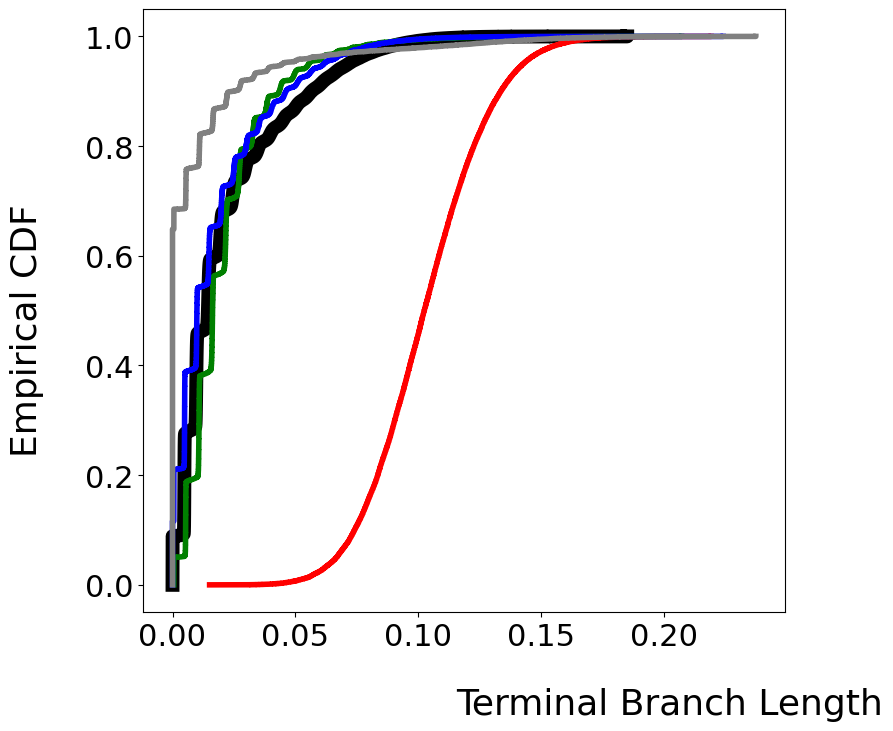

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from Bio import Phylo

def terminal_branch_length_cdf(newick_file, ax=None, label=None, color=None, linewidth=3.0):
    """
    Compute and optionally plot the empirical CDF of terminal branch lengths.
    
    Parameters
    ----------
    newick_file : str
        Path to the Newick tree file.
    ax : matplotlib.axes.Axes, optional
        Axis to plot on. If None, a new figure is created.
    label : str, optional
        Label for the curve (useful when comparing multiple trees).
    color : str, optional
        Color for the curve.
    linewidth : float
        Line width for the plot.
    
    Returns
    -------
    lengths : np.ndarray
        Sorted terminal branch lengths.
    cdf : np.ndarray
        Corresponding CDF values (from 0 to 1).
    """
    try:
        tree = Phylo.read(newick_file, "newick")
    except FileNotFoundError:
        print(f"File not found: {newick_file}. Skipping.")
        return None, None
        
    # --- Extract terminal branch lengths ---
    # Only consider terminals with a branch length defined
    lengths = [clade.branch_length for clade in tree.get_terminals()
               if clade.branch_length is not None]
    lengths = np.array(lengths)
    lengths.sort()
    
    if len(lengths) == 0:
        print(f"No valid terminal branch lengths found in {newick_file}. Skipping.")
        return None, None

    # --- Compute empirical CDF ---
    cdf = np.arange(1, len(lengths)+1) / len(lengths)
    
    # Use 'steps-post' drawstyle for the CDF plot
    ax.plot(lengths, cdf, linewidth=linewidth, drawstyle="steps-post", label=label, color=color)
    
    # Apply styling (moved to main plot section for consistency)
    
    return lengths, cdf


# --- Data and Parameter Setup ---

# The CDF plot focuses on the PSE enzyme, so we only need one main title.
# We'll use the title "PSE1" from the first script.
main_title = "PSE1 - Terminal Branch Length CDF" 

# Define files, labels, and colors as in the original CDF script
files_pse = [
    "../../data_directed_evolution/TreeSingleThread_PSE_round20.nwk",
    "../../data_directed_evolution/TreeSingleThread_PSE_mcmc_samples100000_T1.3_steps120_pairs10000.nwk",
    "../../data_directed_evolution/TreeSingleThread_nodupl_PSE_popgen_samples1000000_T12.0_mu0.03_mubind-50.0_pairs10000.fa.nwk",
    "../../data_directed_evolution/TreeSingleThread_PSE_mcmctree_T1.4_steps110_pairs10000.nwk",
    "../../data_directed_evolution/TreeSingleThread_PSE_neutral_samples100000_T0.0_mu0.012_mubind0.0_pairs10000.nwk"
]


# Define files, labels, and colors as in the original CDF script
files_tem = [
    "../../data_directed_evolution/TreeSingleThread_PSE_round20.nwk",
    "../../data_directed_evolution/TreeSingleThread_PSE_mcmc_samples100000_T1.3_steps120_pairs10000.nwk",
    "../../data_directed_evolution/TreeSingleThread_nodupl_PSE_popgen_samples1000000_T12.0_mu0.03_mubind-50.0_pairs10000.fa.nwk",
    "../../data_directed_evolution/TreeSingleThread_PSE_mcmctree_T1.4_steps110_pairs10000.nwk",
    "../../data_directed_evolution/TreeSingleThread_PSE_neutral_samples100000_T0.0_mu0.012_mubind0.0_pairs10000.nwk"
]


# Define files, labels, and colors as in the original CDF script
files_aac = [
    "../../data_directed_evolution/TreeSingleThread_PSE_round20.nwk",
    "../../data_directed_evolution/TreeSingleThread_PSE_mcmc_samples100000_T1.3_steps120_pairs10000.nwk",
    "../../data_directed_evolution/TreeSingleThread_nodupl_PSE_popgen_samples1000000_T12.0_mu0.03_mubind-50.0_pairs10000.fa.nwk",
    "../../data_directed_evolution/TreeSingleThread_PSE_mcmctree_T1.4_steps110_pairs10000.nwk",
    "../../data_directed_evolution/TreeSingleThread_PSE_neutral_samples100000_T0.0_mu0.012_mubind0.0_pairs10000.nwk"
]


# Define files, labels, and colors as in the original CDF script
files_dhfr = [
    "../../data_directed_evolution/TreeSingleThread_PSE_round20.nwk",
    "../../data_directed_evolution/TreeSingleThread_PSE_mcmc_samples100000_T1.3_steps120_pairs10000.nwk",
    "../../data_directed_evolution/TreeSingleThread_nodupl_PSE_popgen_samples1000000_T12.0_mu0.03_mubind-50.0_pairs10000.fa.nwk",
    "../../data_directed_evolution/TreeSingleThread_PSE_mcmctree_T1.4_steps110_pairs10000.nwk",
    "../../data_directed_evolution/TreeSingleThread_PSE_neutral_samples100000_T0.0_mu0.012_mubind0.0_pairs10000.nwk"
]


labels = ["Exp", "MCMC", "Pop Gen", "MCMC on tree", "Neutral"]
# Adapting colors and line widths from the first script's style for Exp (black) and models (colored)
# The first script uses line widths: Exp=10, Models=4. We'll use that ratio.
colors_map = {
    "Exp": "black",
    "MCMC": "red",
    "Pop Gen": "green",
    "MCMC on tree": "blue",
    "Neutral": "grey" # The first script didn't have 'Neutral', using grey for a model
}
linewidths_map = {
    "Exp": 10.0,
    "MCMC": 4.0,
    "Pop Gen": 4.0,
    "MCMC on tree": 4.0,
    "Neutral": 4.0
}


# --- Plotting Setup (Using first script's style) ---

# Figure size and subplot structure from the first script (1 row, 4 columns)
# Even though we only plot one CDF, keeping the structure allows using common labels/legend logic.
fig, axs = plt.subplots(1, 4, figsize=(30, 8), sharey=False)


# --- Plot the CDFs ---
for path, label in zip(files_pse, labels):
    color = colors_map[label]
    linewidth = linewidths_map[label]
    print(path) # Keep the print statement for tracking
    terminal_branch_length_cdf(path, label=label, ax=axs[0], color=color, linewidth=linewidth)

    # --- Plot the CDFs ---
for path, label in zip(files_tem, labels):
    color = colors_map[label]
    linewidth = linewidths_map[label]
    print(path) # Keep the print statement for tracking
    terminal_branch_length_cdf(path, label=label, ax=axs[1], color=color, linewidth=linewidth)

    # --- Plot the CDFs ---
for path, label in zip(files_aac, labels):
    color = colors_map[label]
    linewidth = linewidths_map[label]
    print(path) # Keep the print statement for tracking
    terminal_branch_length_cdf(path, label=label, ax=axs[2], color=color, linewidth=linewidth)

    # --- Plot the CDFs ---
for path, label in zip(files_dhfr, labels):
    color = colors_map[label]
    linewidth = linewidths_map[label]
    print(path) # Keep the print statement for tracking
    terminal_branch_length_cdf(path, label=label, ax=axs[3], color=color, linewidth=linewidth)


# --- Apply Styling (Mimicking first script) ---


# Hide the unused subplots
for i in range(1, 4):
    axs[i].set_visible(False)

# Adjust tick label size for the *used* axis
ax.tick_params(axis="both", labelsize=22)

# Set axis labels with specific font sizes
ax.set_xlabel("Terminal branch length", fontsize=26)
ax.set_ylabel("Empirical CDF", fontsize=26)

# Common axis labels (adapting the density/Hamming distance labels to the CDF context)
# The first script uses fig.text for common labels.

# fig.text(0.03, 0.5, "Density", va="center", rotation="vertical", fontsize=26) # Modified below
# fig.text(0.5, 0.02, "Pairwise Normalized Hamming Distance", ha="center", fontsize=26) # Modified below

# Adapt the common labels to the CDF plot
# Move axis labels out of the subplot and use fig.text for a 'common' feel
ax.set_xlabel("") # Clear subplot x-label
ax.set_ylabel("") # Clear subplot y-label

# Common Y-axis label (position adjusted for the single visible plot)
fig.text(0.03, 0.5, "Empirical CDF", va="center", rotation="vertical", fontsize=26)

# Common X-axis label (position adjusted for the single visible plot)
fig.text(0.25, 0.02, "Terminal Branch Length", ha="center", fontsize=26)



# Adjust layout (Using first script's style)
fig.tight_layout(rect=[0.05, 0.08, 0.95, 0.92])

plt.savefig("../../pse_cdf_branch_length_styled.png", dpi=700)

# Show and save
plt.show()

Starting data generation and saving to directory: ../../data_directed_evolution/best_fit/cdfs/
Data generation complete.
Plot saved to: ../../terminal_branch_length_cdf_comparison.png


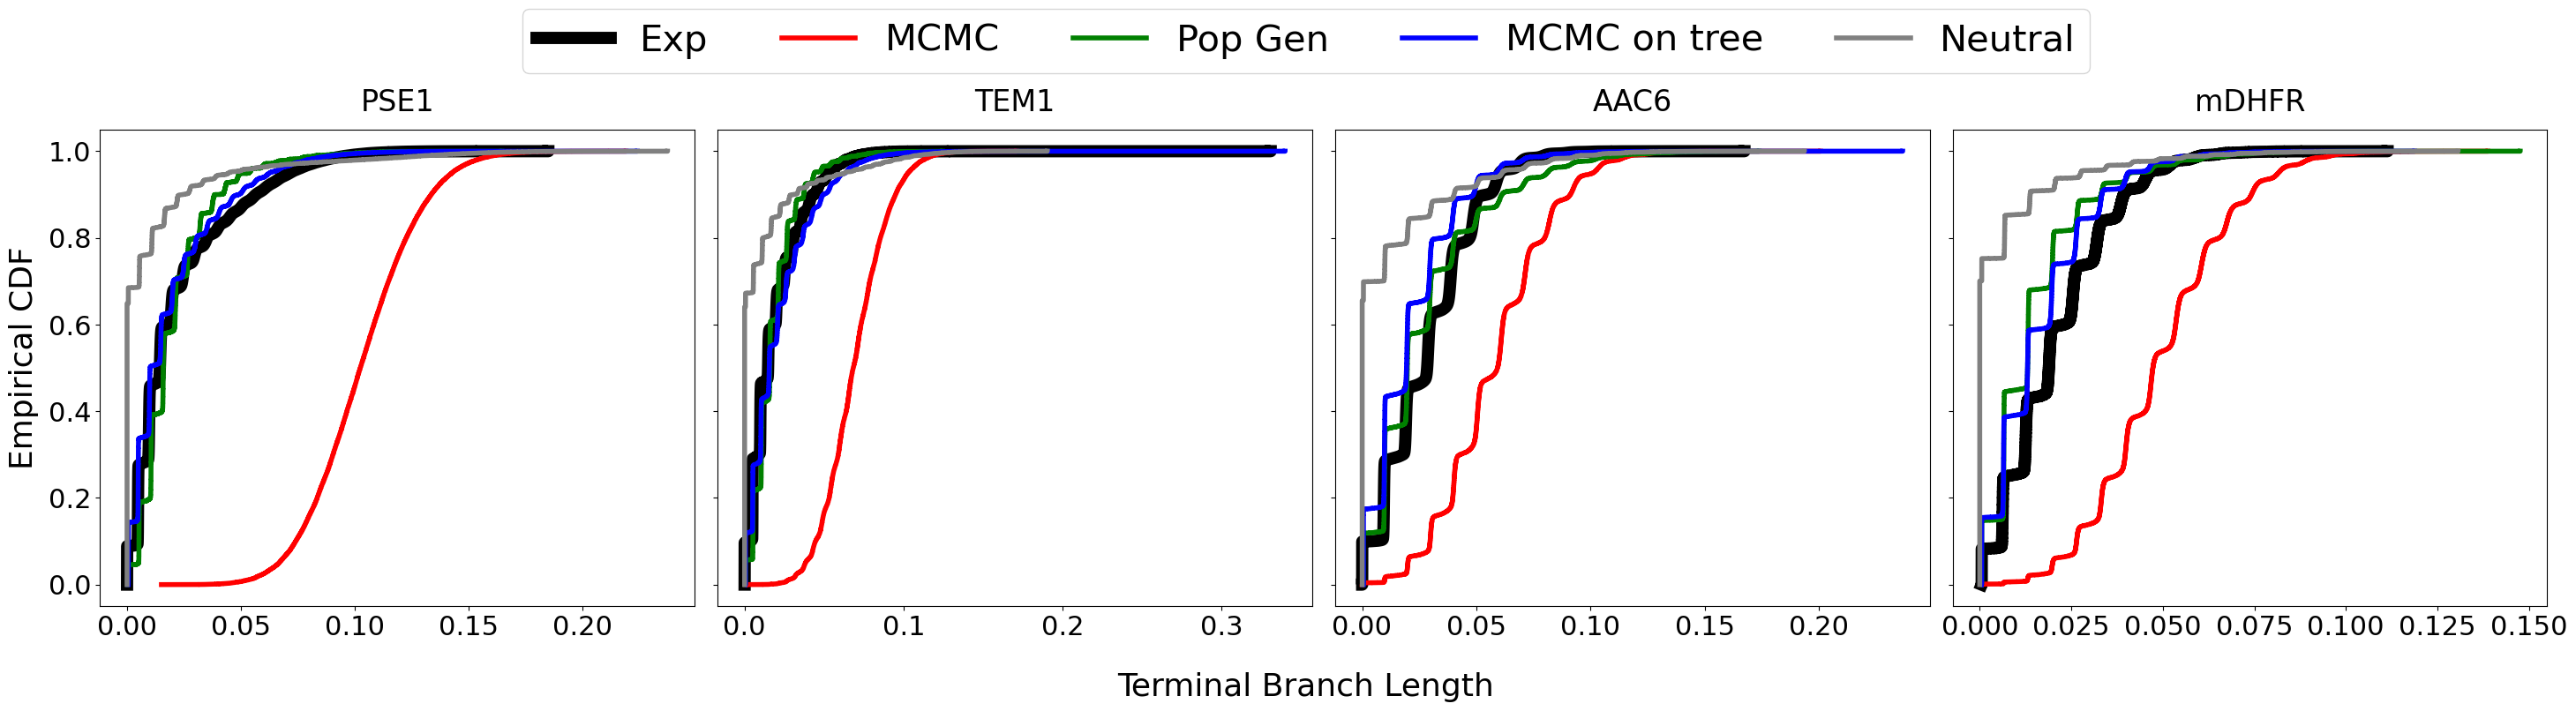

In [4]:
import numpy as np
from Bio import Phylo
import matplotlib.pyplot as plt
import os
import sys



def calculate_and_save_cdf(newick_file, output_dir, wt_name, model_label):
    """
    Computes the empirical CDF of terminal branch lengths and saves the 
    (lengths, cdf) arrays to separate .txt files.
    
    Returns (lengths, cdf) arrays, or (None, None) on failure.
    """
    try:
        # NOTE: Adjust file path handling if running outside the intended directory structure.
        tree = Phylo.read(newick_file, "newick")
    except FileNotFoundError:
        print(f"File not found: {newick_file}. Skipping.")
        return None, None
    except Exception as e:
        print(f"Error reading or parsing {newick_file}: {e}. Skipping.")
        return None, None
        
    # --- Extract terminal branch lengths ---
    lengths = [clade.branch_length for clade in tree.get_terminals()
               if clade.branch_length is not None]
    lengths = np.array(lengths)
    lengths.sort()
    
    if len(lengths) == 0:
        return None, None

    # --- Compute empirical CDF ---
    cdf = np.arange(1, len(lengths)+1) / len(lengths)
    
    # --- Data Saving (for Julia) ---
    os.makedirs(output_dir, exist_ok=True)
    
    base_name = f"{wt_name}_{model_label.replace(' ', '_')}_cdf"
    
    # Save the X-data (Terminal Branch Lengths)
    x_filename = os.path.join(output_dir, f"{base_name}_lengths.txt")
    np.savetxt(x_filename, lengths, fmt='%f')
    
    # Save the Y-data (Empirical CDF)
    y_filename = os.path.join(output_dir, f"{base_name}_cdf.txt")
    np.savetxt(y_filename, cdf, fmt='%f')
    
    return lengths, cdf


# --- File and Parameter Setup ---

base_path = "../../data_directed_evolution/"

# NOTE: Since the TEM, AAC, and DHFR lists in the original code pointed to PSE files,
# this script maintains that pattern to generate data arrays of the same size/count, 
# but the resulting plots/data for TEM/AAC/DHFR will be identical to PSE.
files_pse = [
    f"{base_path}TreeSingleThread_PSE_round20.nwk",
    f"{base_path}TreeSingleThread_PSE_mcmc_samples100000_T1.3_steps120_pairs10000.nwk",
    f"{base_path}TreeSingleThread_nodupl_PSE_popgen_samples100000_T12.0_mu0.03_mubind-50.0_pairs10000.nwk",
    f"{base_path}TreeSingleThread_nodupl_PSE_mcmctree.nwk",
    f"{base_path}TreeSingleThread_PSE_neutral_samples100000_T0.0_mu0.012_mubind0.0_pairs10000.nwk"
]


files_tem = [
    f"{base_path}TreeSingleThread_TEM_round12.nwk",
    f"{base_path}TreeSingleThread_TEM_mcmc_samples100000_T1.1_steps95_pairs10000.nwk",
    f"{base_path}TreeSingleThread_nodupl_TEM_popgen_samples100000_T6.0_mu0.035_mubind-50.0_pairs10000.nwk",
    f"{base_path}TreeSingleThread_nodupl_TEM_mcmctree.nwk",
    f"{base_path}TreeSingleThread_TEM_neutral_samples100000_T0.0_mu0.014_mubind0.0_pairs10000.nwk"
]

files_aac = [
    f"{base_path}TreeSingleThread_AAC6_round8.nwk",
    f"{base_path}TreeSingleThread_AAC_mcmc_samples100000_T2.1_steps30_pairs10000.nwk",
    f"{base_path}TreeSingleThread_nodupl_AAC_popgen_samples100000_T10.0_mu0.035_mubind0.0_pairs10000.nwk",
    f"{base_path}TreeSingleThread_nodupl_AAC_mcmctree.nwk",
    f"{base_path}TreeSingleThread_AAC_neutral_samples100000_T0.0_mu0.018_mubind0.0_pairs10000.nwk"
]

files_dhfr = [
    f"{base_path}TreeSingleThread_DHFR_round15.nwk",
    f"{base_path}TreeSingleThread_DHFR_mcmc_samples100000_T2.3_steps50_pairs10000.nwk",
    f"{base_path}TreeSingleThread_nodupl_DHFR_popgen_samples1000000_T8.0_mu0.02_mubind10.0_pairs10000.nwk",
    f"{base_path}TreeSingleThread_nodupl_DHFR_mcmctree.nwk",
    f"{base_path}TreeSingleThread_DHFR_neutral_samples100000_T0.0_mu0.007_mubind0.0_pairs10000.nwk"]


all_files = [files_pse, files_tem, files_aac, files_dhfr]
labels = ["Exp", "MCMC", "Pop Gen", "MCMC on tree", "Neutral"]
wt_names = ["PSE1", "TEM1", "AAC6", "mDHFR"] # Corrected to wt_name

# Line styles and colors inspired by the pairwise Hamming distance plot
colors_map = {
    "Exp": "black", "MCMC": "red", "Pop Gen": "green", 
    "MCMC on tree": "blue", "Neutral": "grey" 
}
linewidths_map = {
    "Exp": 10.0, "MCMC": 4.0, "Pop Gen": 4.0, 
    "MCMC on tree": 4.0, "Neutral": 4.0
}


# --- Configuration for Output ---
# This directory will be created to store the generated CDF data files.
OUTPUT_DIR = "../../data_directed_evolution/best_fit/cdfs/"
OUTPUT_PLT_PATH = "../../terminal_branch_length_cdf_comparison.png"


# --- Data Generation and Storage ---

cdf_data = {} 
print(f"Starting data generation and saving to directory: {OUTPUT_DIR}")

for wt_idx, wt_files in enumerate(all_files):
    wt_name = wt_names[wt_idx]
    cdf_data[wt_name] = {}
    
    for model_idx, file_path in enumerate(wt_files):
        model_label = labels[model_idx]
        
        # Calculate CDF and save the data to .txt files
        lengths, cdf = calculate_and_save_cdf(file_path, OUTPUT_DIR, wt_name, model_label)
        
        # Store the calculated data for plotting
        if lengths is not None:
            cdf_data[wt_name][model_label] = (lengths, cdf)
        else:
             print(f"Warning: No data stored for {wt_name} - {model_label}.")
print("Data generation complete.")

# --- Plotting and Styling ---

# Figure setup
fig, axs = plt.subplots(1, 4, figsize=(30, 8), sharey=True)

# Iterate through all four wt_names and their stored data
for i, wt_name in enumerate(wt_names):
    ax = axs[i]
    wt_data = cdf_data.get(wt_name, {})
    
    # Plot all CDF lines for the current wt_name
    for label in labels:
        if label in wt_data:
            # Retrieve the pre-calculated x (lengths) and y (cdf) data
            lengths, cdf = wt_data[label]
            
            # Retrieve styling parameters
            color = colors_map[label]
            linewidth = linewidths_map[label]
            
            # Plot the data using the required styling
            ax.plot(lengths, cdf, linewidth=linewidth, drawstyle="steps-post", label=label, color=color)
        
    # Apply subplot-specific styling
    ax.set_title(wt_name, fontsize=24, pad=15)
    ax.tick_params(axis="both", labelsize=22)
    
    # Hide y-axis labels for all but the first plot for a clean, shared y-axis look
    if i > 0:
        ax.tick_params(labelleft=False)
    
    # Clear subplot x/y labels to use common labels instead
    ax.set_xlabel("")
    ax.set_ylabel("")


# --- Apply Common Styling and Saving Plot ---

# Common Y-axis label 
fig.text(0.01, 0.5, "Empirical CDF", va="center", rotation="vertical", fontsize=26)

# Common X-axis label 
fig.text(0.5, 0.02, "Terminal Branch Length", ha="center", fontsize=26)

# Shared legend 
fig.legend(labels, loc="upper center", ncol=len(labels), bbox_to_anchor=(0.5, 1.02), fontsize=30)

# Adjust layout
fig.tight_layout(rect=[0.02, 0.08, 0.98, 0.90])

# Save the figure
plt.savefig(OUTPUT_PLT_PATH, dpi=700)
print(f"Plot saved to: {OUTPUT_PLT_PATH}")

# Optional: show the plot
# plt.show()

In [2]:
pip install Bio

  Using cached bio-1.8.1-py3-none-any.whl.metadata (5.7 kB)
  Using cached biopython-1.86-cp313-cp313-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl.metadata (13 kB)
  Using cached gprofiler_official-1.0.0-py3-none-any.whl.metadata (11 kB)
  Using cached mygene-3.2.2-py2.py3-none-any.whl.metadata (10 kB)
  Using cached pooch-1.8.2-py3-none-any.whl.metadata (10 kB)
  Using cached biothings_client-0.4.1-py3-none-any.whl.metadata (10 kB)
Using cached bio-1.8.1-py3-none-any.whl (321 kB)
Using cached biopython-1.86-cp313-cp313-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl (3.2 MB)
Using cached gprofiler_official-1.0.0-py3-none-any.whl (9.3 kB)
Using cached mygene-3.2.2-py2.py3-none-any.whl (5.4 kB)
Using cached biothings_client-0.4.1-py3-none-any.whl (46 kB)
Using cached pooch-1.8.2-py3-none-any.whl (64 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [Bio]5/6 [Bio]
Note: you may need to restart the kernel to use updated packages.


Processing: ../../data_directed_evolution/TreeSingleThread_PSE_round20.nwk
Processing: ../../data_directed_evolution/TreeSingleThread_PSE_mcmc_samples100000_T1.3_steps120_pairs10000.nwk
Processing: ../../data_directed_evolution/TreeSingleThread_nodupl_PSE_popgen_samples1000000_T12.0_mu0.03_mubind-50.0_pairs10000.fa.nwk
Processing: ../../data_directed_evolution/TreeSingleThread_PSE_mcmctree_T1.4_steps110_pairs10000.nwk
Processing: ../../data_directed_evolution/TreeSingleThread_PSE_neutral_samples100000_T0.0_mu0.012_mubind0.0_pairs10000.nwk


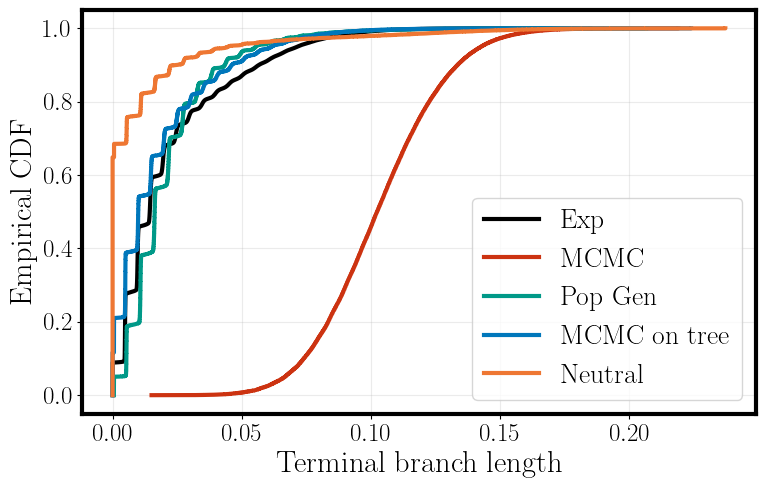

In [10]:
from Bio import Phylo
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Custom Formatting Setup (Aligned with Julia/PyPlot rcParams) ---
def setup_plot_style():
    """Sets Matplotlib global parameters for consistent styling."""
    mpl = plt.matplotlib
    rcParams = mpl.rcParams

    rcParams["text.latex.preamble"] = r"\usepackage{amsmath}"
    
    # LaTeX formatting
    rcParams["text.usetex"] = True
    rcParams["font.family"] = "serif"
    rcParams["font.size"] = 18
    
    # Axes and Label Sizing
    rcParams["axes.labelsize"] = 22 # From the Julia function
    rcParams["legend.fontsize"] = 20 # From the Julia function
    rcParams["axes.linewidth"] = 3.0 # Axis line thickness
    
    # General line width for the CDF plot
    rcParams["lines.linewidth"] = 3.0 
    
    # Use standard line width for plot function
    # Note: We will explicitly set linewidth in the plot call as well
    
    
def terminal_branch_length_cdf(newick_file, ax=None, label=None, color=None):
    """
    Compute and optionally plot the empirical CDF of terminal branch lengths.
    (Function remains largely the same, but uses the global style)
    """
    try:
        tree = Phylo.read(newick_file, "newick")
    except Exception as e:
        print(f"Error reading {newick_file}: {e}")
        return np.array([]), np.array([])
        
    # --- Extract terminal branch lengths ---
    lengths = [clade.branch_length for clade in tree.get_terminals() 
               if clade.branch_length is not None]
    lengths = np.array(lengths)
    lengths.sort()
    
    if len(lengths) == 0:
        return np.array([]), np.array([])

    # --- Compute empirical CDF ---
    cdf = np.arange(1, len(lengths)+1) / len(lengths)
    
    # --- Plot if axis is provided ---
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 5)) # Use smaller, consistent size
        
    # Use drawstyle="steps-post" for CDF plot, keeping linewidth=3
    ax.plot(lengths, cdf, linewidth = 3., drawstyle="steps-post", label=label, color=color)
    
    return lengths, cdf

# ----------------------------------------------------------------------
# --- Execution with Aligned Formatting ---
# ----------------------------------------------------------------------

# 0. Set up the plotting style once
setup_plot_style()

files = [
    "../../data_directed_evolution/TreeSingleThread_PSE_round20.nwk",
    "../../data_directed_evolution/TreeSingleThread_PSE_mcmc_samples100000_T1.3_steps120_pairs10000.nwk",
    "../../data_directed_evolution/TreeSingleThread_nodupl_PSE_popgen_samples1000000_T12.0_mu0.03_mubind-50.0_pairs10000.fa.nwk",
    "../../data_directed_evolution/TreeSingleThread_PSE_mcmctree_T1.4_steps110_pairs10000.nwk",
    "../../data_directed_evolution/TreeSingleThread_PSE_neutral_samples100000_T0.0_mu0.012_mubind0.0_pairs10000.nwk"
]
labels = ["Exp", "MCMC", "Pop Gen", "MCMC on tree", "Neutral"]
colors = ["black", "#CC3311", "#009988", "#0077BB", "#EE7733"] # Using default_colors from your Julia inspiration

# Use a consistent figure size
fig, ax = plt.subplots(figsize=(8, 6)) 

for path, label, color in zip(files, labels, colors):
    print(f"Processing: {path}")
    terminal_branch_length_cdf(path, label=label, ax=ax, color=color)

# --- 2. Final Touches (Aligned Axes and Grid) ---

# Set aligned labels using LaTeX
ax.set_xlabel(r"Terminal branch length", fontsize=22) 
ax.set_ylabel(r"Empirical CDF", fontsize=22) 

# Add grid (aligned with the inspiration function)
ax.grid(True, alpha=0.25)

# Add Legend
ax.legend(loc="lower right") 

# Ensure tight layout for a clean fit
fig.tight_layout(rect=[0, 0.03, 1, 0.9]) # Adjust rect to make room for suptitle

plt.savefig("../../pse_cdf_branch_length.pdf", bbox_inches="tight")
plt.show() # Use plt.show() if running interactively

In [ ]:
ENV["PYTHON"] = "" 
using Pkg
Pkg.build("PyCall")  # Rebuild PyCall to use the internal Python

using Revise, PhyloTools, TreeTools, DCAUtils, JLD2, PyPlot, Statistics, DelimitedFiles

files = [
    "../data_directed_evolution/TreeSingleThread_PSE_round20.nwk",
    "../data_directed_evolution/TreeSingleThread_PSE_mcmc_samples100000_T1.3_steps120_pairs10000.nwk",
    "../data_directed_evolution/TreeSingleThread_nodupl_PSE_popgen_samples1000000_T12.0_mu0.03_mubind-50.0_pairs10000.fa.nwk",
    "../data_directed_evolution/TreeSingleThread_PSE_mcmctree_T1.4_steps110_pairs10000.nwk",
    "../data_directed_evolution/TreeSingleThread_PSE_neutral_samples100000_T0.0_mu0.012_mubind0.0_pairs10000.nwk"
]

labels = ["Exp", "MCMC", "Pop Gen", "MCMC on tree", "Neutral"]
colors = ["black", "red", "green", "blue", "grey"]

close("all")
for i in 1:length(files)
    tree = read_tree(files[i], node_data_type = Seq);    
    dd = [distance(tree.root, a) for a in leaves(tree)];
    plt.hist(dd, histtype = "step", linewidth = 3., color = colors[i], label = labels[i], density = true)
end
plt.xlabel("Root-leaf branch length",fontsize = 15)
plt.ylabel("Density", fontsize = 15)
plt.yscale("log")
plt.legend()
savefig("../popgen_rootleaf.png", dpi = 300)

    







Exp: Mean=0.0016, Std=0.0028, N=3
MCMC: Mean=0.0034, Std=0.0025, N=3
Pop Gen: Mean=0.0005, Std=0.0000, N=3
MCMC on tree: Mean=0.0022, Std=0.0022, N=3
Neutral: Mean=0.0006, Std=0.0000, N=3


/tmp/ipykernel_217/2867516349.py:68: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(all_branches, labels=labels, patch_artist=True)



Boxplot saved to root_branches_boxplot.png

Summary Statistics:
Exp             - Mean:   0.0016, Std:   0.0028, N: 3
MCMC            - Mean:   0.0034, Std:   0.0025, N: 3
Pop Gen         - Mean:   0.0005, Std:   0.0000, N: 3
MCMC on tree    - Mean:   0.0022, Std:   0.0022, N: 3
Neutral         - Mean:   0.0006, Std:   0.0000, N: 3


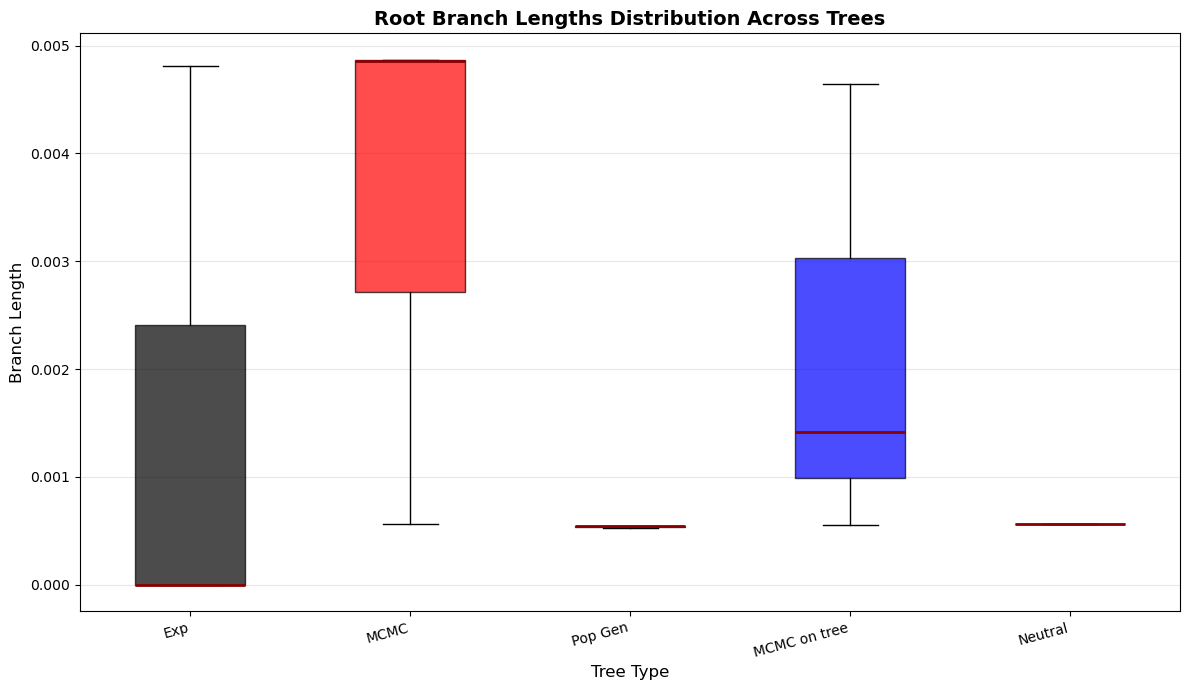

In [6]:
from Bio import Phylo
import matplotlib.pyplot as plt
import numpy as np

def analyze_root_branches(files, labels, colors, output_file='root_branches_boxplot.png'):
    """
    Analyze root branch lengths from multiple phylogenetic trees.
    
    Parameters:
    -----------
    files : list of str
        List of paths to tree files (Newick, Nexus, or PhyloXML format)
    labels : list of str
        List of labels for each tree
    colors : list of str
        List of colors for each boxplot
    output_file : str
        Path for saving the output boxplot
    
    Returns:
    --------
    dict : Statistics for each tree (mean, std, branch_lengths)
    """
    
    all_stats = {}
    all_branches = []
    
    # Process each tree file
    for i, (file, label) in enumerate(zip(files, labels)):
        # Read the tree - auto-detect format
        try:
            tree = Phylo.read(file, 'newick')
        except:
            try:
                tree = Phylo.read(file, 'nexus')
            except:
                tree = Phylo.read(file, 'phyloxml')
        
        # Get root node
        root = tree.root
        
        # Extract branch lengths from root to its direct children
        root_branches = []
        for child in root.clades:
            if child.branch_length is not None:
                root_branches.append(child.branch_length)
        
        if not root_branches:
            print(f"Warning: No branch lengths found for {label}")
            root_branches = [0]
        
        all_branches.append(root_branches)
        
        # Compute statistics
        all_stats[label] = {
            'branch_lengths': root_branches,
            'mean': np.mean(root_branches),
            'std': np.std(root_branches, ddof=1) if len(root_branches) > 1 else 0,
            'count': len(root_branches)
        }
        
        print(f"{label}: Mean={all_stats[label]['mean']:.4f}, Std={all_stats[label]['std']:.4f}, N={all_stats[label]['count']}")
    
    # Create boxplot
    fig, ax = plt.subplots(figsize=(12, 7))
    
    # Create box plot
    bp = ax.boxplot(all_branches, labels=labels, patch_artist=True)
    
    # Color the boxes
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    # Color the medians
    for median in bp['medians']:
        median.set_color('darkred')
        median.set_linewidth(2)
    
    ax.set_ylabel('Branch Length', fontsize=12)
    ax.set_xlabel('Tree Type', fontsize=12)
    ax.set_title('Root Branch Lengths Distribution Across Trees', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    
    # Rotate x-axis labels if needed
    plt.xticks(rotation=15, ha='right')
    
    plt.tight_layout()
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    print(f"\nBoxplot saved to {output_file}")
    
    return all_stats


# Example usage:
if __name__ == "__main__":
    files = [
        "../../data_directed_evolution/TreeSingleThread_PSE_round20.nwk",
        "../../data_directed_evolution/TreeSingleThread_PSE_mcmc_samples100000_T1.3_steps120_pairs10000.nwk",
        "../../data_directed_evolution/TreeSingleThread_nodupl_PSE_popgen_samples1000000_T12.0_mu0.03_mubind-50.0_pairs10000.fa.nwk",
        "../../data_directed_evolution/TreeSingleThread_PSE_mcmctree_T1.4_steps110_pairs10000.nwk",
        "../../data_directed_evolution/TreeSingleThread_PSE_popgen_samples100000_T0.0_mu0.03_mubind-50.0_pairs10000.nwk"
    ]
    labels = ["Exp", "MCMC", "Pop Gen", "MCMC on tree", "Neutral"]
    colors = ["black", "red", "green", "blue", "grey"]
    
    # Run analysis
    stats = analyze_root_branches(files, labels, colors)
    
    # Print summary statistics
    print("\n" + "="*60)
    print("Summary Statistics:")
    print("="*60)
    for label in labels:
        s = stats[label]
        print(f"{label:15s} - Mean: {s['mean']:8.4f}, Std: {s['std']:8.4f}, N: {s['count']}")

In [ ]:
from Bio import Phylo
import matplotlib.pyplot as plt

# Load the Newick tree
tree = Phylo.read("../../data_directed_evolution/TreeSingleThread_PSE_popgen_samples100000_T12.0_mu0.03_mubind-50.0_pairs10000.nwk", "newick")



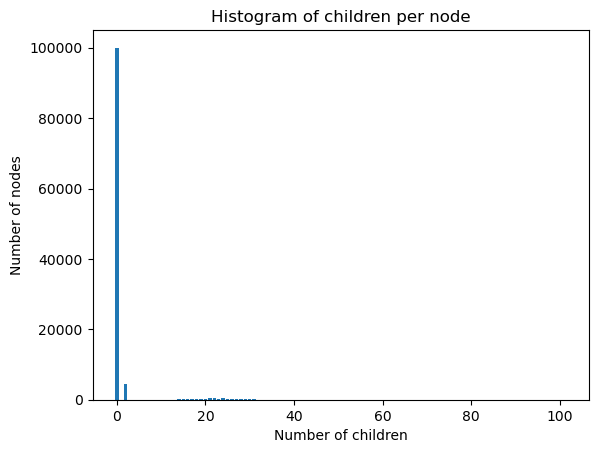

In [8]:
from Bio import Phylo
import matplotlib.pyplot as plt

# Load the Newick tree
tree = Phylo.read("../../data_directed_evolution/TreeSingleThread_PSE_popgen_samples100000_T12.0_mu0.03_mubind-50.0_pairs10000.nwk", "newick")

# Collect number of children for each node
children_counts = []

for clade in tree.find_clades():
    children_counts.append(len(clade.clades))  # number of children of this node

# Plot histogram
plt.hist(children_counts, bins=range(max(children_counts)+2), align="left", rwidth=0.8)
plt.xlabel("Number of children")
plt.ylabel("Number of nodes")
plt.title("Histogram of children per node")
plt.show()


In [9]:
from Bio import Phylo
import matplotlib.pyplot as plt

def plot_children_hist(newick_files, labels, colors):
    """
    Plot histograms of number of children per node for multiple Newick trees.
    
    Parameters
    ----------
    newick_files : list of str
        Paths to Newick files.
    labels : list of str
        Labels for each tree (used in the legend).
    colors : list of str
        Colors for each histogram.
    """
    plt.figure(figsize=(8, 6))

    for file, label, color in zip(newick_files, labels, colors):
        tree = Phylo.read(file, "newick")
        children_counts = [len(clade.clades) for clade in tree.find_clades()]

        plt.hist(
            children_counts,
            bins=range(max(children_counts) + 2),
            align="left",
            rwidth=0.6,
            alpha=0.5,
            label=label,
            color=color
        )

    plt.xlabel("Number of children")
    plt.ylabel("Number of nodes")
    plt.title("Histogram of children per node")
    plt.legend()
    plt.show()


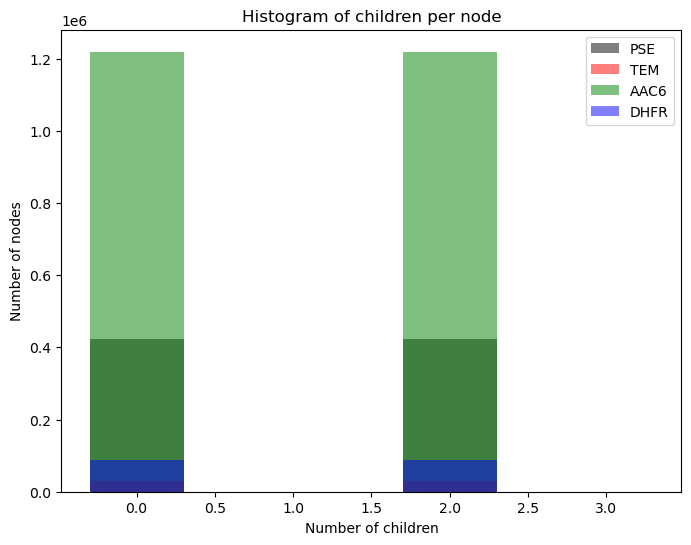

In [10]:
files = [
    "../../data_directed_evolution/TreeSingleThread_PSE_round20.nwk",
    "../../data_directed_evolution/TreeSingleThread_TEM_round12.nwk",
    "../../data_directed_evolution/TreeSingleThread_AAC6_round8.nwk",
    "../../data_directed_evolution/TreeSingleThread_DHFR_round15.nwk",
]
labels = ["PSE", "TEM", "AAC6", "DHFR"]
colors = ["black", "red", "green", "blue"]
plot_children_hist(files, labels, colors)

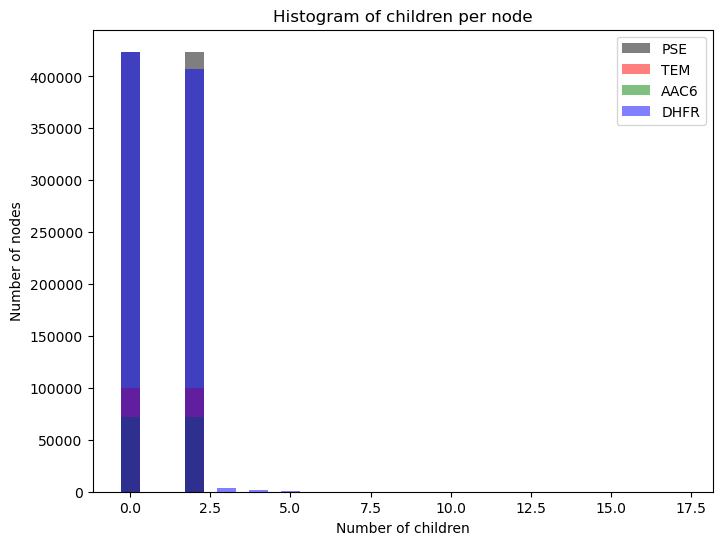

In [11]:
files = [
    "../../data_directed_evolution/TreeSingleThread_PSE_round20.nwk",
    "../../data_directed_evolution/TreeSingleThread_PSE_mcmc_samples100000_T1.3_steps120_pairs10000.nwk",
    "../../data_directed_evolution/TreeSingleThread_nodupl_PSE_popgen_samples1000000_T12.0_mu0.03_mubind-50.0_pairs10000.fa.nwk",
    "../../data_directed_evolution/TreeSingleThread_PSE_mcmctree_T1.4_steps110_pairs10000.nwk"
]
labels = ["PSE", "TEM", "AAC6", "DHFR"]
colors = ["black", "red", "green", "blue"]
plot_children_hist(files, labels, colors)